In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv", \
                    header=0, usecols=['age', 'bmi', 'children', 'charges'])
data

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [3]:
# Standardize Predictors
data['bmi'] = (data['bmi'] - data['bmi'].mean()) / data['bmi'].std()
data['age'] = (data['age'] - data['age'].mean()) / data['age'].std()
data['children'] = (data['children'] - data['children'].mean()) / data['children'].std()
data['charges'] = (data['charges'] - data['charges'].mean()) / data['charges'].std()
data


,age,bmi,children,charges
0,-1.438227,-0.453151,-0.908274,0.298472
1,-1.509401,0.509431,-0.078738,-0.953333
2,-0.797655,0.383164,1.580335,-0.728402
3,-0.441782,-1.305043,-0.908274,0.719574
4,-0.512957,-0.292447,-0.908274,-0.776512
...,...,...,...,...
1333,0.768185,0.050278,1.580335,-0.220468
1334,-1.509401,0.206062,-0.908274,-0.913661
1335,-1.509401,1.014499,-0.908274,-0.961237
1336,-1.295877,-0.797515,-0.908274,-0.930014


In [67]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [76]:
# Prepare data for Stan
N_train = len(train_data)
x_train = np.column_stack((train_data['age'], train_data['bmi'], train_data['children']))
y_train = train_data['charges'].to_numpy()
K = x_train.shape[1]

stan_data = {
    'N': N_train,
    'K': K,
    'x': x_train,
    'y': y_train,
    'tau_0': 1,
    'tau_1': 1,
    'sigma_alpha': 5,
    'sigma_beta': np.array([5, 5, 5])
}

In [77]:
vectorized_program_code = """
data {
    int<lower=0> N;         
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;
    
    real<lower=0> tau_0; 
    real<lower=0> tau_1; 
    real<lower=0> sigma_alpha; 
    vector<lower=0>[K] sigma_beta;        
}

parameters {
    real alpha; 
    vector[K] beta; 
    real<lower=0> sigma2; 
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    sigma2 ~ inv_gamma(tau_0, tau_1);
    alpha ~ normal(0, sigma_alpha);
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    y ~ normal(alpha + x*beta, sigma);
}
"""

In [82]:
vectorized_program_code = """
data {
    int<lower=0> N;         
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;
    
    real<lower=0> tau_0; 
    real<lower=0> tau_1; 
    real<lower=0> sigma_alpha; 
    vector<lower=0>[K] sigma_beta;        
}

parameters {
    real alpha; 
    vector[K] beta; 
    real<lower=0> sigma2; 
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    target += inv_gamma_lpdf(sigma2 | tau_0, tau_1);
    target += normal_lpdf(alpha | 0, sigma_alpha);
    target += multi_normal_lpdf(beta | rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    target += normal_lpdf(y | alpha + x*beta, sigma);
}
"""

In [83]:
vectorized_posterior = stan.build(vectorized_program_code, data=stan_data, random_seed=42)

fit_vectorized = vectorized_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: 39.2s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000143 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.0001 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the follo

In [84]:
summary = az.summary(fit_vectorized)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.028,-0.047,0.059,0.0,0.0,10180.0,6501.0,1.0
beta[0],0.256,0.029,0.200,0.308,0.0,0.0,9822.0,5466.0,1.0
beta[1],0.167,0.029,0.111,0.220,0.0,0.0,10425.0,6689.0,1.0
beta[2],0.056,0.029,-0.001,0.106,0.0,0.0,10540.0,6349.0,1.0
sigma2,0.881,0.039,0.810,0.955,0.0,0.0,8585.0,6027.0,1.0
sigma,0.939,0.021,0.900,0.977,0.0,0.0,8585.0,6027.0,1.0


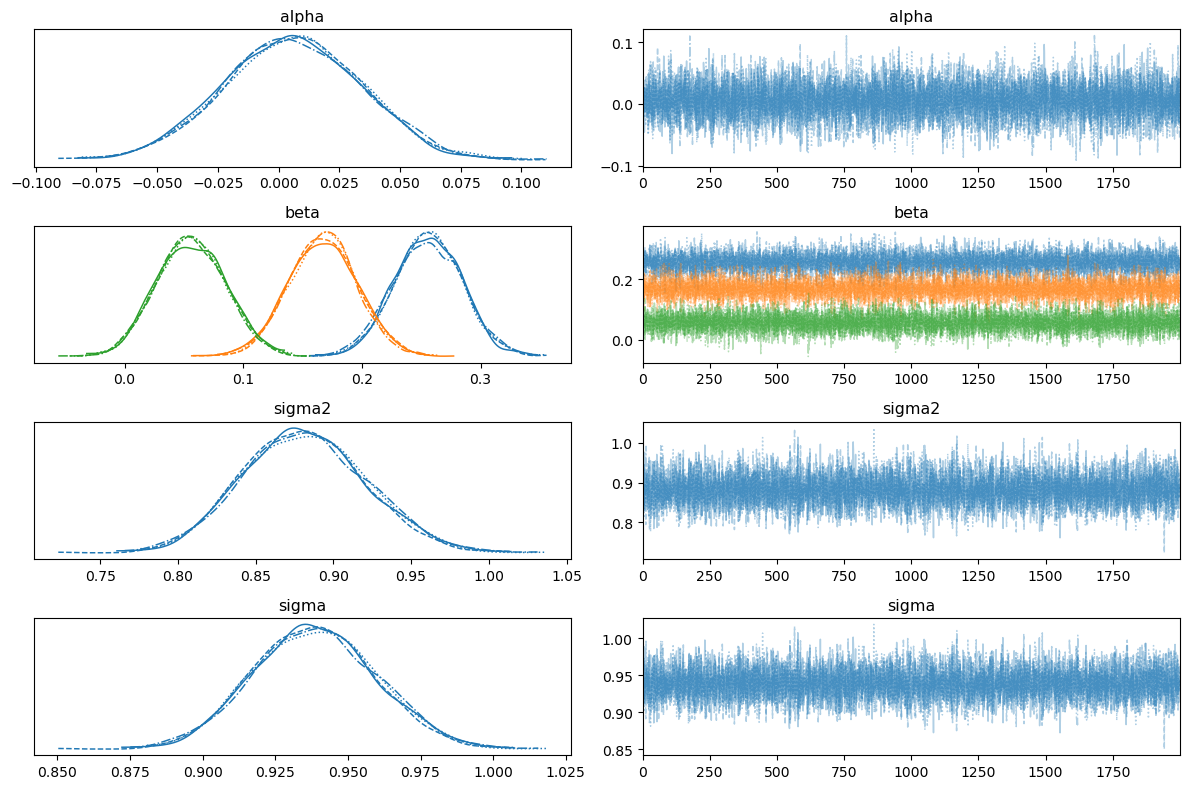

In [85]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit_vectorized)
plt.tight_layout()